# Workshop 8 - Introduction to Deep Neural Networks

Code for workshop 8.  This will use Keras (within tensorflow v2) to build a small fully connected network. 

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Our new Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

In [3]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


## Load data
We will use fashion MNIST, which is a set of small images (28x28) that contain 10 different fashion items - see below for class names and an example image.

In [4]:
# This is a built-in data for keras, so easily accessible
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
Coat


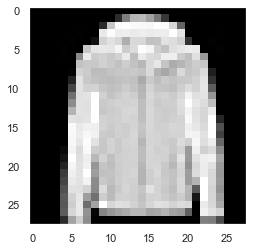

In [6]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/???
X_val, X_train = X_train_full[:5000]/???, X_train_full[5000:]/??? 
y_val, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "T-shirt/top" , "Trouser" , "Pullover" , "Dress" , "Coat" , "Sandal" , 
               "Shirt" , "Sneaker" , "Bag" , "Ankle boot" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_val.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

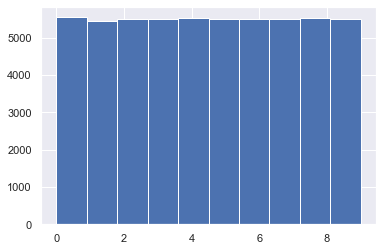

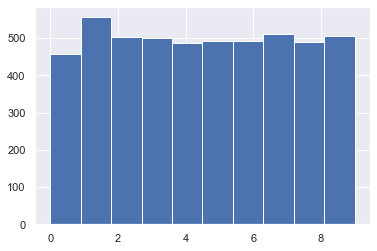

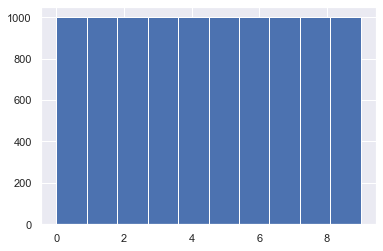

In [7]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_val)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [8]:
# This is *all* the code needed to define the network architecture
#  1 input layer + 2 hidden layers of sizes 300 and 100 + 1 output layer
model = keras.models.Sequential()   # This is a style of building networks - the easiest option
model.add(keras.layers.Flatten(input_shape = [28 , 28]))   # our inputs are 28 x 28 arrays, so need to become 1D
model.add(keras.layers.Dense(300, activation = "relu"))    # first hidden layer
model.add(keras.layers.Dense(100, activation = "relu"))    # second hidden layer
model.add(keras.layers.Dense(10, activation = "softmax"))  # output layer

2022-05-04 18:46:07.901037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Print out some info on the network - take note of the number of parameters (weights and biases)
# Can you calculate the number of parameters yourself?
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Couple the architecture definition to a loss function and optimiser (and other performance metrics)
# Note that we use sparse_categorical_crossentropy because the entries in y_train are just numbers from 0 to 9
# If y_train was encoded as one-hot vectors, then the appropriate loss would be categorical_crossentropy instead
# We will use the SGD optimiser here, but Adam is another popular choice
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [11]:
# Now train (fit) the model, specifying appropriate data and number of epochs (small here to save time)
# Save the history of metrics versus epochs - *always* keep this
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7073 - accuracy: 0.7693 - val_loss: 0.5258 - val_accuracy: 0.8192
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4880 - accuracy: 0.8293 - val_loss: 0.4538 - val_accuracy: 0.8440
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4423 - accuracy: 0.8459 - val_loss: 0.4189 - val_accuracy: 0.8590
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4154 - accuracy: 0.8547 - val_loss: 0.3927 - val_accuracy: 0.8678
Epoch 5/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3958 - accuracy: 0.8617 - val_loss: 0.3977 - val_accuracy: 0.8628


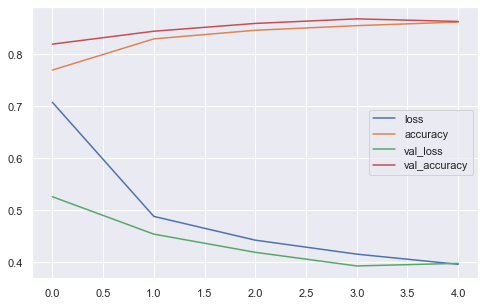

In [12]:
# Simple way to plot the history information (see later for more detail)
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.show()

In [13]:
# Now we can run the model on any data and get results (loss and accuracy both reported)
valres = model.evaluate(X_val, y_val, verbose=0)
print(valres)

[0.39768409729003906, 0.8628000020980835]


In [14]:
# We can look at the probability of predicting each class for each image
# Each row has ten probabilities (one per class)
y_pred = model.predict(X_val[:3])  # use the first three validation cases as an example
print(y_pred.round(2))  # round to two decimal places when printing

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.94 0.   0.   0.   0.   0.   0.06 0.   0.   0.  ]
 [0.32 0.08 0.09 0.29 0.11 0.   0.11 0.   0.01 0.  ]]


[9 0 0]
['Ankle boot' 'T-shirt/top' 'T-shirt/top']
['Ankle boot' 'T-shirt/top' 'T-shirt/top']


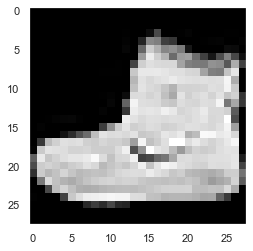

In [15]:
# We can inspect the output class predictions by find the class with maximum probability
y_pred = np.argmax(model.predict(X_val[:3]), axis=-1)
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_val[:3]])   # names of true classes
# Display an image of the first validation sample
plt.imshow(X_val[0].reshape((28,28)), cmap="gray")
plt.grid(False)

# Now for a little more detail

For example, why make these particular choices for architecture and parameters.

We will set up some more general code so that we can build and compare a range of networks.

In [16]:
# More general settings
# Let's allow the size of the training and validation sets to change
#n_train = n_total   # as above
#n_val = 5000      # as above
n_train = 5000   # smaller set
n_val = 1000
# Define the number and size of hidden layers
#hiddensizes = [300, 100]  # this was what we did above
hiddensizes = [100]   # instead, try a simpler one (only one layer)
# Define the activation function to be used by hidden layers
actfn = "relu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01
# Set size of batch and number of epochs
batch_size = 50
n_epochs = 20

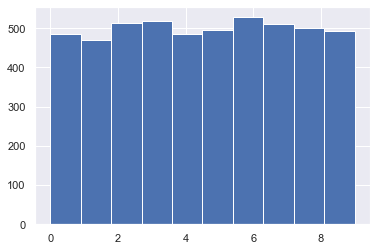

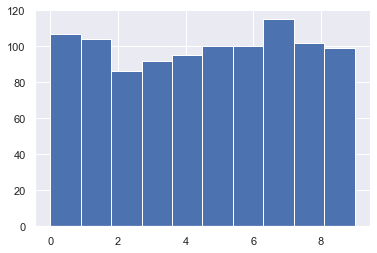

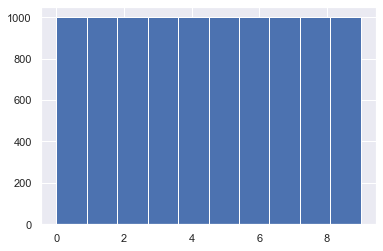

In [17]:
# Let's look at the distribution of labels in the training, validation and test sets we will use
plt.hist(y_train[:n_train])
plt.show()
plt.hist(y_val[:n_val])
plt.show()
plt.hist(y_test)
plt.show()

In [18]:
# Build a more general model using various settings
def model_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28 , 28]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [19]:
# Create our model
model = model_factory(hiddensizes, ???, optimizer, learningrate)
# Show summary info
model.summary()
# Train it  ####################################
history = model.fit(X_train[:n_train], y_train[:n_train], epochs=n_epochs, validation_data=(X_val[:n_val], y_val[:n_val]), 
                    batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
100/100 [==============================] - 0s 2ms/step - loss: 1.6601 - accuracy: 0.5114 - val_loss: 1.2599 - val_accuracy: 0.6610
Epoch 2/20
100/100 [==============================] - 0s 1ms/step - loss: 1.1141 - accuracy: 0.6708 - val_loss: 0.9863 - val_accuracy: 0.7030
Epoch 3/20
100/100 [==========

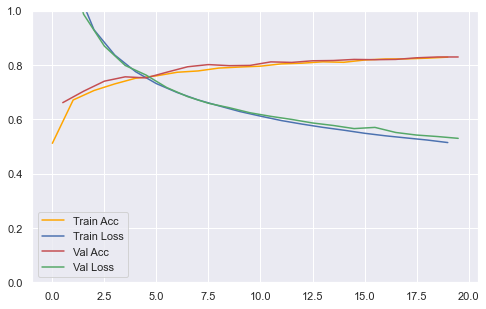

In [20]:
# Plot the results (shifting validation curves appropriately)
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,n_epochs),history.history['accuracy'], color='orange')
plt.plot(np.arange(0,n_epochs),history.history['loss'],'b')
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_loss'],'g')
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show() 

In [21]:
# Display best accuracy on validation set
max_val_acc = np.max(history.history['val_accuracy'])
print(f'Best validation accuracy = {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places
# Evaluate on full validation dataset (or the test set if all tuning and selection is finished)
valres = model.evaluate(X_val, ???, verbose=0)
print(f'Accuracy on all validation data = {valres[1]:.3f}')

Best validation accuracy = 0.829
Accuracy on all validation data = 0.828


In [22]:
# This function does everything: creates a model, trains it, then returns a performance measure
# Note that I have been a bit lazy here in not passing in the data explicit (X_train, y_train, X_val, y_val)
#  - this is generally bad practice, but makes this a little easier to see here as a learning exercise, but don't do this in practice
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_val, n_epochs, batch_size):
    # Create our model
    model = model_factory(hiddensizes, actfn, optimizer, learningrate)
    # Train it
    history = model.fit(???[:n_train], ???[:n_train], epochs=n_epochs, validation_data=(X_val[:n_val], y_val[:n_val]), 
                        batch_size=batch_size)
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history)

In [23]:
# Use the previous function to allow us to select options for our Deep Learning model randomly and then see how that performs
def random_model():
    # Make some random selections to see how performance varies with network size and training set size
    lsize=[10,100,1000]   # just have three options for layer sizes
    # start with three candidate layers
    hiddensizes = [lsize[np.random.randint(0,3)], lsize[np.random.randint(0,3)], lsize[np.random.randint(0,3)]]
    # then keep between 1 and 3 layers
    hiddensizes = hiddensizes[:np.random.randint(1,4)]
    n_train = np.random.randint(1,10)*10**np.random.randint(2,4)  # numbers between 100 and 9000 (logarithmically selected)
    n_epochs = 10  # to speed things up a bit (not recommended for proper evaluation)
    # Now build, run and report
    valacc, history = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_val, n_epochs, batch_size)
    print(f'Settings are: {(hiddensizes, actfn, optimizer, learningrate, n_train, n_val, n_epochs, batch_size)}')
    print(f'Validation accuracy = {valacc:.3f}')
    retval = [hiddensizes, n_train, valacc]
    return retval

In [24]:
res = random_model()

Epoch 1/10
180/180 [==============================] - 0s 2ms/step - loss: 1.9403 - accuracy: 0.3068 - val_loss: 1.6123 - val_accuracy: 0.4740
Epoch 2/10
180/180 [==============================] - 0s 1ms/step - loss: 1.3108 - accuracy: 0.5812 - val_loss: 1.0415 - val_accuracy: 0.6580
Epoch 3/10
180/180 [==============================] - 0s 1ms/step - loss: 0.9236 - accuracy: 0.6906 - val_loss: 0.8067 - val_accuracy: 0.7020
Epoch 4/10
180/180 [==============================] - 0s 1ms/step - loss: 0.7744 - accuracy: 0.7209 - val_loss: 0.7034 - val_accuracy: 0.7490
Epoch 5/10
180/180 [==============================] - 0s 1ms/step - loss: 0.7071 - accuracy: 0.7392 - val_loss: 0.6675 - val_accuracy: 0.7510
Epoch 6/10
180/180 [==============================] - 0s 1ms/step - loss: 0.6644 - accuracy: 0.7492 - val_loss: 0.6225 - val_accuracy: 0.7770
Epoch 7/10
180/180 [==============================] - 0s 1ms/step - loss: 0.6401 - accuracy: 0.7578 - val_loss: 0.5990 - val_accuracy: 0.7950
Epoch 

In [25]:
print(res)

[[100, 100, 10], 9000, 0.7950000166893005]


## What to do now

 - Explore what differences these options make
 - Use the results to select a best model
 - Measure its performance on the test set
 - Compare it to the performance on the validation set

In [26]:
nreps = 40
allres = []
for n in range(nreps):
    res = random_model()
    allres += [res]

Epoch 1/10
14/14 [==============================] - 0s 9ms/step - loss: 2.3353 - accuracy: 0.0714 - val_loss: 2.2873 - val_accuracy: 0.0980
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 2.2639 - accuracy: 0.1243 - val_loss: 2.2473 - val_accuracy: 0.1250
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 2.2334 - accuracy: 0.1514 - val_loss: 2.2219 - val_accuracy: 0.1610
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 2.2084 - accuracy: 0.1771 - val_loss: 2.2016 - val_accuracy: 0.1800
Epoch 5/10
14/14 [==============================] - 0s 3ms/step - loss: 2.1874 - accuracy: 0.2129 - val_loss: 2.1841 - val_accuracy: 0.1820
Epoch 6/10
14/14 [==============================] - 0s 3ms/step - loss: 2.1692 - accuracy: 0.2229 - val_loss: 2.1663 - val_accuracy: 0.1850
Epoch 7/10
14/14 [==============================] - 0s 3ms/step - loss: 2.1518 - accuracy: 0.2000 - val_loss: 2.1512 - val_accuracy: 0.1960
Epoch 8/10
14/14 [==

In [27]:
allresmat = np.array(allres,dtype=object)
valaccs = allresmat[:,2]
print(valaccs)
bestres=allresmat[int(np.argmax(valaccs)),:]
print(bestres)

[0.23999999463558197 0.20999999344348907 0.2669999897480011
 0.31200000643730164 0.7519999742507935 0.7799999713897705
 0.2750000059604645 0.734000027179718 0.8130000233650208
 0.7139999866485596 0.7929999828338623 0.32100000977516174
 0.8259999752044678 0.7099999785423279 0.7490000128746033
 0.10700000077486038 0.5350000262260437 0.43700000643730164
 0.3310000002384186 0.49900001287460327 0.7559999823570251
 0.7099999785423279 0.35899999737739563 0.48500001430511475
 0.8199999928474426 0.625 0.6919999718666077 0.6299999952316284
 0.718999981880188 0.8259999752044678 0.28700000047683716
 0.5329999923706055 0.22100000083446503 0.6579999923706055
 0.7900000214576721 0.671999990940094 0.4650000035762787
 0.18400000035762787 0.5070000290870667 0.34700000286102295]
[list([1000, 1000, 1000]) 6000 0.8259999752044678]


[2, 3, 2, 3, 1, 2, 1, 1, 2, 2, 2, 1, 3, 1, 3, 3, 1, 3, 3, 1, 2, 3, 3, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 3, 1, 2]


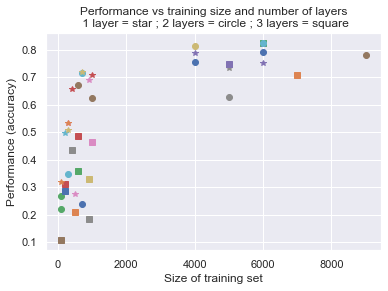

In [43]:
# Plot the performance versus training set size, with number of layers shown via shape
nlayers = [len(res[0]) for res in allres]
print(nlayers)
plotshape = ['*','o','s']
for n in range(allresmat.shape[0]):
    plt.plot(allresmat[n,1],allresmat[n,2],plotshape[nlayers[n]-1])
plt.title('Performance vs training size and number of layers\n 1 layer = star ; 2 layers = circle ; 3 layers = square')
plt.xlabel('Size of training set')
plt.ylabel('Performance (accuracy)')
plt.show()

# Comments on plot
Note how there the best performing methods (closer to the top) consist of instances with one, two or three layers (represented by the star, circle and square shapes). From this it can be seen that the training size (on the x-axis) is much more important. Though remember that this is true here, for this particular set of networks and this particular task, and it might be different in other situations.

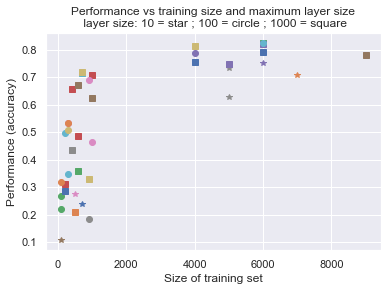

In [44]:
# Plot the performance versus training set size, with maximum layer size shown via shape
maxlayersize = [np.max(res[0]) for res in allres]
maxlslog = np.log10(maxlayersize).astype(int)
plotshape = ['*','o','s']
for n in range(allresmat.shape[0]):
    plt.plot(allresmat[n,1],allresmat[n,2],plotshape[maxlslog[n]-1])
plt.title('Performance vs training size and maximum layer size\n layer size: 10 = star ; 100 = circle ; 1000 = square')
plt.xlabel('Size of training set')
plt.ylabel('Performance (accuracy)')
plt.show()

# Comments on plot
Note that although all maximum layer sizes (as shown by different shapes) are represented in the top performing networks, the square (max size = 1000) tends to dominate, showing that this probably matters more than number of layers. However, note that small layer sized network (no layers more than 10) are still present, as shown by the stars.  Hence it is not the case that all small networks do badly, in fact small networks can do well, but there is probably a better chance of getting the best performance (in this particular case) by having larger layer sizes. 

In [29]:
hiddensizes = bestres[0]
n_train = bestres[1]
model = model_factory(hiddensizes, actfn, optimizer, learningrate)
history = model.fit(X_train[:n_train], y_train[:n_train], epochs=n_epochs, validation_data=(X_val[:n_val], y_val[:n_val]), 
                    batch_size=batch_size)
max_val_acc = np.max(history.history['val_accuracy'])
testres = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/20
120/120 [==============================] - 2s 10ms/step - loss: 1.5856 - accuracy: 0.5780 - val_loss: 1.0651 - val_accuracy: 0.7100
Epoch 2/20
120/120 [==============================] - 1s 9ms/step - loss: 0.9206 - accuracy: 0.7108 - val_loss: 0.7907 - val_accuracy: 0.7760
Epoch 3/20
120/120 [==============================] - 1s 9ms/step - loss: 0.7550 - accuracy: 0.7527 - val_loss: 0.7076 - val_accuracy: 0.7720
Epoch 4/20
120/120 [==============================] - 1s 10ms/step - loss: 0.6761 - accuracy: 0.7757 - val_loss: 0.6362 - val_accuracy: 0.8080
Epoch 5/20
120/120 [==============================] - 1s 9ms/step - loss: 0.6265 - accuracy: 0.7910 - val_loss: 0.6161 - val_accuracy: 0.7970
Epoch 6/20
120/120 [==============================] - 1s 9ms/step - loss: 0.5900 - accuracy: 0.8023 - val_loss: 0.5593 - val_accuracy: 0.8270
Epoch 7/20
120/120 [==============================] - 1s 10ms/step - loss: 0.5567 - accuracy: 0.8122 - val_loss: 0.5511 - val_accuracy: 0.8260
Epo

In [30]:
print(f'Final results: sizes = {hiddensizes}, n_train = {n_train}, val_accuracy = {max_val_acc:.3f} and test_accuracy = {testres[1]:.3f}')

Final results: sizes = [1000, 1000, 1000], n_train = 6000, val_accuracy = 0.857 and test_accuracy = 0.824


# Comments on final result
You can see that for the best result the test accuracy is not that much smaller than the validation accuracy, which shows good generalisation.